In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# Load the dataset
# Make sure your 'media_weekly.csv' file is in the same directory as this notebook.
df = pd.read_csv('/media_weekly.csv')

# Convert the 'week' column to datetime and set it as the index
df['week'] = pd.to_datetime(df['week'])
df.set_index('week', inplace=True)

# Handle any missing values by forward-filling them from the last known value
df.ffill(inplace=True)

print("Step 1: Data loaded and initial cleaning complete. Here's the raw data head:")
print("-" * 50)
display(df.head())

Step 1: Data loaded and initial cleaning complete. Here's the raw data head:
--------------------------------------------------


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
week,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [18]:
# Use log transformation to handle skewness and stabilize the model
df['log_revenue'] = np.log1p(df['revenue'])
df['log_average_price'] = np.log1p(df['average_price'])

print("Step 2: Log transformations applied. Notice the new log_revenue column:")
print("-" * 50)
display(df.head())

Step 2: Log transformations applied. Notice the new log_revenue column:
--------------------------------------------------


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,log_revenue,log_average_price
week,,,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,11.328103,4.634243
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,5.924309,4.652626
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,6.242243,4.618876
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,6.117612,4.645736
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,10.632073,4.689144


In [19]:
# Feature Engineering: Create time-based features
df['trend'] = np.arange(len(df)) + 1
df['week_of_year'] = df.index.isocalendar().week.astype(int)
df['quarter'] = df.index.quarter

print("Step 3: Trend and seasonality features added:")
print("-" * 50)
display(df.head())

Step 3: Trend and seasonality features added:
--------------------------------------------------


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,log_revenue,log_average_price,trend,week_of_year,quarter
week,,,,,,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,11.328103,4.634243,1,37,3
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,5.924309,4.652626,2,38,3
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,6.242243,4.618876,3,39,4
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,6.117612,4.645736,4,40,4
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,10.632073,4.689144,5,41,4


In [20]:
# Adstock Transformation function
def adstock_transform(series, decay_rate):
    adstocked_series = series.copy()
    for i in range(1, len(series)):
        adstocked_series.iloc[i] = series.iloc[i] + adstocked_series.iloc[i-1] * decay_rate
    return adstocked_series

# Apply the adstock transformation to all media spend columns
media_channels = ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
decay_rate = 0.5
for channel in media_channels:
    df[f'{channel}_adstock'] = adstock_transform(df[channel], decay_rate)

print("Step 4: Adstock transformation applied. Notice the new adstocked columns:")
print("-" * 50)
display(df.head())

Step 4: Adstock transformation applied. Notice the new adstocked columns:
--------------------------------------------------


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,...,log_revenue,log_average_price,trend,week_of_year,quarter,facebook_spend_adstock,google_spend_adstock,tiktok_spend_adstock,instagram_spend_adstock,snapchat_spend_adstock
week,,,,,,,,,,,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,...,11.328103,4.634243,1,37,3,6030.800,3130.14000,2993.22000,1841.0800,2204.720
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,...,5.924309,4.652626,2,38,3,8256.840,4269.07000,1496.61000,920.5400,1102.360
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,...,6.242243,4.618876,3,39,4,10021.420,2134.53500,748.30500,460.2700,551.180
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,...,6.117612,4.645736,4,40,4,12177.870,1067.26750,374.15250,230.1350,275.590
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,...,10.632073,4.689144,5,41,4,11449.225,533.63375,187.07625,3352.2175,137.795


In [21]:
# Define the features and targets for our two-stage model
X_stage1 = df[[f'{c}_adstock' for c in media_channels if c != 'google_spend']]
y_stage1 = df['google_spend_adstock']
y_stage2 = df['log_revenue']

print("Step 5: Features and targets defined. Data preparation is complete.")
print("-" * 50)

Step 5: Features and targets defined. Data preparation is complete.
--------------------------------------------------


In [22]:
# Two-Stage Lasso Regression with Time-Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
stage2_metrics = []

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    scaler_stage1 = StandardScaler()
    X1_train_scaled = scaler_stage1.fit_transform(X_stage1.loc[df_train.index])
    X1_test_scaled = scaler_stage1.transform(X_stage1.loc[df_test.index])
    lasso_stage1 = Lasso(alpha=0.1, max_iter=10000)
    lasso_stage1.fit(X1_train_scaled, y_stage1.loc[df_train.index])
    predicted_google_spend = lasso_stage1.predict(X1_test_scaled)

    X2_train = df_train.drop(columns=['revenue', 'google_spend'] + media_channels)
    X2_test = df_test.drop(columns=['revenue', 'google_spend'] + media_channels)
    X2_train['predicted_google_spend_adstock'] = lasso_stage1.predict(scaler_stage1.transform(X_stage1.loc[df_train.index]))
    X2_test['predicted_google_spend_adstock'] = predicted_google_spend
    X2_train['log_average_price'] = df_train['log_average_price']
    X2_test['log_average_price'] = df_test['log_average_price']

    scaler_stage2 = StandardScaler()
    X2_train_scaled = scaler_stage2.fit_transform(X2_train)
    X2_test_scaled = scaler_stage2.transform(X2_test)
    lasso_stage2 = Lasso(alpha=0.1, max_iter=10000)
    lasso_stage2.fit(X2_train_scaled, y_stage2.loc[df_train.index])
    predicted_log_revenue = lasso_stage2.predict(X2_test_scaled)

    stage2_r2 = r2_score(y_stage2.loc[df_test.index], predicted_log_revenue)
    predicted_revenue_original = np.expm1(predicted_log_revenue)
    stage2_mape = np.mean(np.abs((df_test['revenue'] - predicted_revenue_original) / df_test['revenue'])) * 100

    stage2_metrics.append({'R-squared': stage2_r2, 'MAPE': stage2_mape})

    print(f"--- Fold {i+1} Results ---")
    print(f"R-squared: {stage2_r2:.4f}")
    print(f"MAPE: {stage2_mape:.2f}%")
    print("Stage 2 Coefficients:", lasso_stage2.coef_)
    print("\n")

print("### Overall Cross-Validation Results ###")
print(f"Average Stage 2 R-squared: {np.mean([m['R-squared'] for m in stage2_metrics]):.4f}")
print(f"Average Stage 2 MAPE: {np.mean([m['MAPE'] for m in stage2_metrics]):.2f}%")
print("-" * 50)

--- Fold 1 Results ---
R-squared: 0.9980
MAPE: 13.84%
Stage 2 Coefficients: [ 0.         -0.         -0.         -0.          0.          3.00750652
 -0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.        ]


--- Fold 2 Results ---
R-squared: 0.9990
MAPE: 4.94%
Stage 2 Coefficients: [-0.         -0.         -0.         -0.          0.          3.04283002
 -0.         -0.          0.          0.         -0.          0.
 -0.          0.          0.          0.        ]


--- Fold 3 Results ---
R-squared: 0.9988
MAPE: 18.29%
Stage 2 Coefficients: [-0.        -0.        -0.        -0.         0.         2.7708851
 -0.        -0.         0.         0.        -0.         0.
 -0.         0.         0.         0.       ]


--- Fold 4 Results ---
R-squared: 0.9990
MAPE: 9.06%
Stage 2 Coefficients: [-0.         -0.         -0.          0.          0.          3.16621524
 -0.         -0.          0.          0.         -0.          0.
 -0. 

Step 2: Generating final model outputs for documentation...
--------------------------------------------------


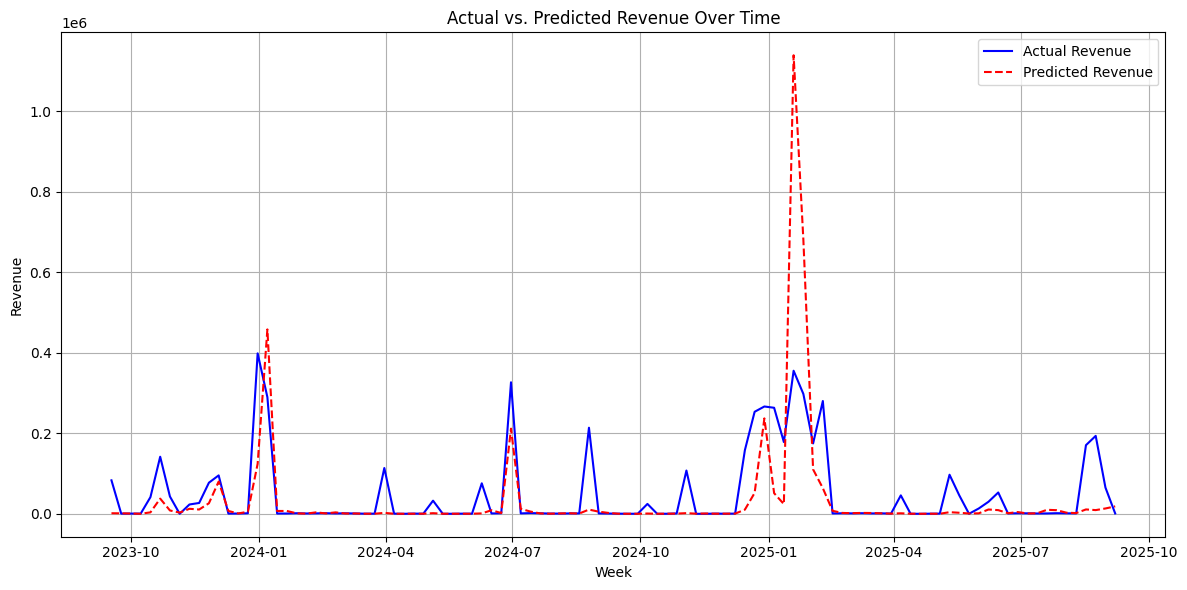

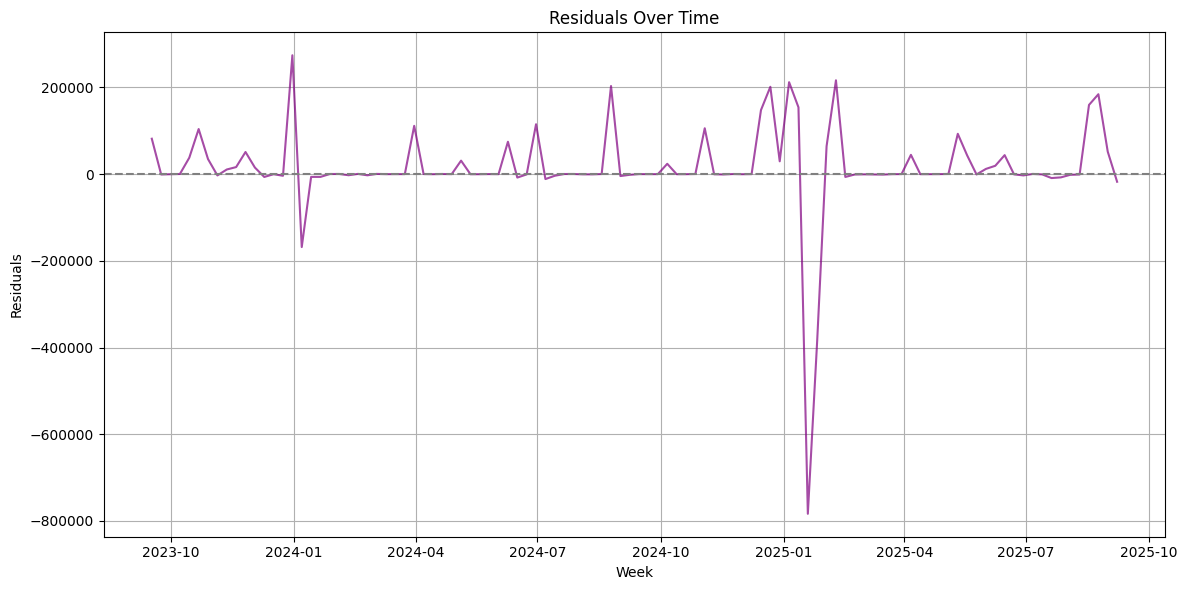

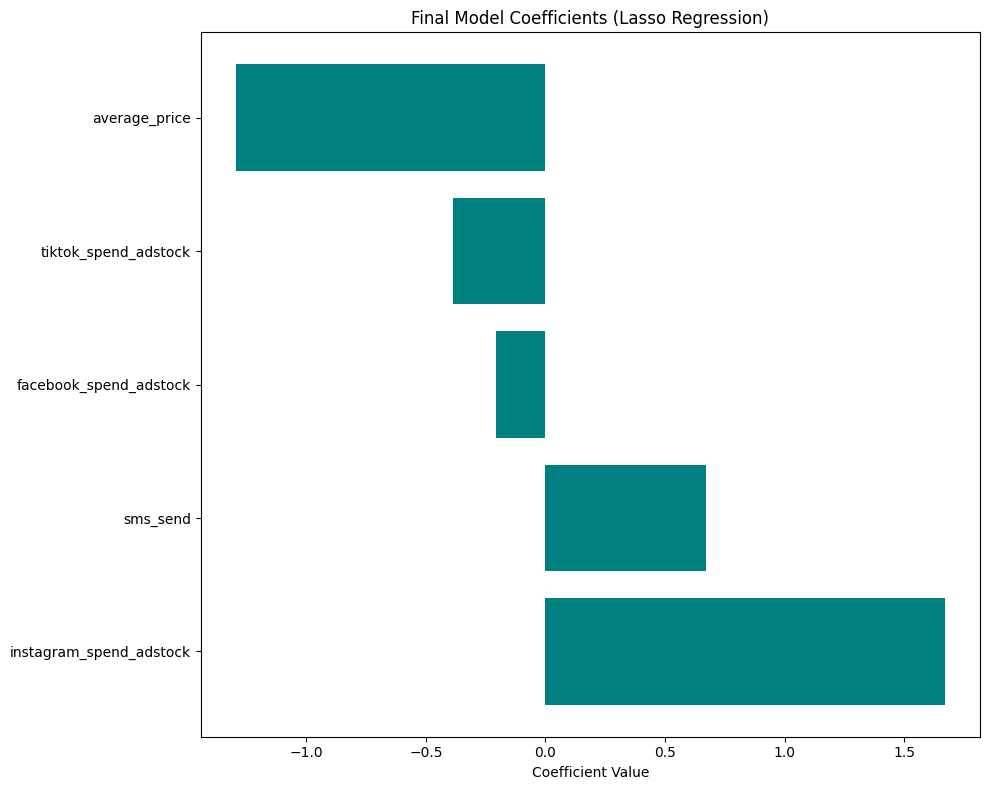

In [23]:
# Fit final model on full dataset for plotting
print("Step 2: Generating final model outputs for documentation...")
print("-" * 50)
scaler_stage1 = StandardScaler()
X1_scaled = scaler_stage1.fit_transform(X_stage1)
lasso_stage1 = Lasso(alpha=0.1, max_iter=10000)
lasso_stage1.fit(X1_scaled, y_stage1)
X2 = df.drop(columns=['revenue', 'log_revenue', 'google_spend'] + media_channels)
X2['predicted_google_spend_adstock'] = lasso_stage1.predict(X1_scaled)
X2['log_average_price'] = df['log_average_price']
scaler_stage2 = StandardScaler()
X2_scaled = scaler_stage2.fit_transform(X2)
lasso_stage2 = Lasso(alpha=0.1, max_iter=10000)
lasso_stage2.fit(X2_scaled, y_stage2)
predicted_log_revenue = lasso_stage2.predict(X2_scaled)
predicted_revenue = np.expm1(predicted_log_revenue)

# Plot 1: Actual vs. Predicted Revenue Over Time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['revenue'], label='Actual Revenue', color='blue')
plt.plot(df.index, predicted_revenue, label='Predicted Revenue', color='red', linestyle='--')
plt.title('Actual vs. Predicted Revenue Over Time')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Residuals Over Time
residuals = df['revenue'] - predicted_revenue
plt.figure(figsize=(12, 6))
plt.plot(df.index, residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Week')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Final Model Coefficients
feature_names = X2.columns
coefficients = lasso_stage2.coef_
non_zero_indices = np.nonzero(coefficients)[0]
non_zero_features = feature_names[non_zero_indices]
non_zero_coefficients = coefficients[non_zero_indices]
sorted_indices = np.argsort(non_zero_coefficients)[::-1]
sorted_features = non_zero_features[sorted_indices]
sorted_coefficients = non_zero_coefficients[sorted_indices]
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color='teal')
plt.xlabel('Coefficient Value')
plt.title('Final Model Coefficients (Lasso Regression)')
plt.tight_layout()
plt.show()